# V5: Drag in Horz direction + height by X[1] change + fuel + PID + 2D + Drag

### Test & Plot - decreasing speed and fuel
- changes: fuel history added to plot it

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interactive  # slider
from matplotlib import rcParams 
from numpy.linalg import norm
from numpy.random import randint
from mpl_toolkits import mplot3d #added for 3D plotting
from scipy.optimize import minimize   # for minimising landing speed
from ipywidgets import interactive 
from matplotlib import rcParams  

rcParams['figure.figsize'] = (10, 8)

In [2]:
def mars_surface():
    surfaceN = randint(5, 15)
    land = np.zeros((surfaceN, 2), dtype=int)
    
    # first ensure there's a flat landing site at least 1000m long
    landing_site = randint(1, surfaceN-1)
    land[landing_site, 0] = randint(2000, 5000)
    land[landing_site+1, 0] = min(land[landing_site, 0] + randint(1000, 2000), 6999)
    land[landing_site+1, 1] = land[landing_site, 1] = randint(1, 1500)
    
    # fill in the rest of the terrain
    for i in range(landing_site):
        land[i, 0] = (land[landing_site, 0] / landing_site) * i
        land[i, 1] = randint(0, 1500)
    
    for i in range(landing_site + 2, surfaceN):
        land[i, 0] = (land[landing_site + 1, 0] + 
                      (7000 - land[landing_site + 1, 0]) / len(land[landing_site + 2:]) * 
                      (i - (landing_site + 1)))
        land[i, 1] = randint(0, 1500)
    
    # impose boundary conditions
    land[0, 0] = 0
    land[-1, 0] = 6999

    return land, landing_site

def plot_surface(land, landing_site):
    fig, ax = plt.subplots()
    ax.plot(land[:landing_site+1, 0], land[:landing_site+1, 1], 'k-')
    ax.plot(land[landing_site+1:, 0], land[landing_site+1:, 1], 'k-')
    ax.plot([land[landing_site, 0], land[landing_site+1, 0]], 
             [land[landing_site, 1], land[landing_site+1, 1]], 'k--')
    ax.set_xlim(0, 7000)
    ax.set_ylim(0, 16000) 
    return ax

def plot_lander(land, landing_site, X, thrust=None, animate=False, step=10):
    if animate:
        def plot_frame(n=len(X)-1):
            ax = plot_surface(land, landing_site)
            ax.plot(X[:n, 0], X[:n, 1], 'b--')      # trajectory of lander
            ax.plot(X[n, 0], X[n, 1], 'k^', ms=20) # lander (color was b)
            if thrust is not None:
                ax.plot([X[n, 0], X[n, 0] - 100*thrust[n, 0]],
                        [X[n, 1] - 100., X[n, 1] - 100. - 100*thrust[n, 1]], 
                       'r-', lw=10)
        return interactive(plot_frame, n=(0, len(X), step)) #slider
    else:
        ax = plot_surface(land, landing_site) 
        ax.plot(X[:, 0], X[:, 1], 'b--')
        ax.plot(X[-1, 0], X[-1, 1], 'b^')
        return ax

def interpolate_surface(land, x):
    i,  = np.argwhere(land[:, 0] < x)[-1] # segment containing x is [i, i+1]
    m = (land[i+1, 1] - land[i, 1])/(land[i+1, 0] - land[i, 0]) # gradient
    x1, y1 = land[i, :] # point on line with eqn. y - y1 = m(x - x1) 
    return m*(x - x1) + y1

land, landing_site = mars_surface()

def height(land, X):
    return X[1] - interpolate_surface(land, X[0]) #1 in X[1] points to the vertical position y of the lander

assert abs(height(land, [1, land[0, 1]])) < 100.0 # height when on surface left edge should be close to zero
assert abs(height(land, [6999, land[-1, 1]])) < 100.0 # height when on surface at right edge should be close to zero

_land, _landing_site = mars_surface()

def _height(_land, X):
    return X[1] - interpolate_surface(_land, X[0])

points = np.zeros((10, 2))
points[:, 0] = randint(0, 7000, size=10)
points[:, 1] = randint(0, 16000, size=10)
for i in range(10):
    assert abs(height(_land, points[i, :]) - _height(_land, points[i, :])) < 1e-6

In [3]:
g = 3.711 # m/s^2 , gravity on Mars
TSFC = 0.0003 # kg/(N*s)
# fuel = 400 kg
Dc = 6.3525 # drag force as a function of velocity

def simulate(X0, V0, land, landing_site, 
             fuel=400, dt=0.1, Nstep=1000, 
             autopilot=None, print_interval=100, parameters=None, parachute=None):
    
    n = len(X0)       # number of degrees of freedom (2 here)
    X = X0.copy()     # current position
    V = np.array(V0).astype(float)  #was X0.copy()     # current velocity
    Xs = np.zeros((Nstep, n)) # position history (trajectory) 
    Vs = np.zeros((Nstep, n)) # velocity history
    Fs = np.zeros((Nstep, n)) # fuel history                
    thrust = np.zeros((Nstep, n)) # thrust history
    drag = np.zeros((Nstep, n)) # drag history
    success = False
    fuel_warning_printed = False
    rotate = randint(-90, 90)            # degrees, initial angle random (heading alignment phase)
    power = 0            # m/s^2, initial thrust power  
    
    e_prev = np.zeros(Nstep) # error history   

    for i in range(Nstep):
        Xs[i, :] = X     # Store positions
        Vs[i, :] = V     # Store velocities
        Fs[i, :] = fuel  # Store fuel values          
        
        if autopilot is not None:
            
            rotate, power, parachute = autopilot(i, X, V, fuel, rotate, power, parameters, parachute,dt,e_prev,Nstep)
            assert abs(rotate) <= 90
            assert 0 <= power <= 12000
        
            rotate_rad = rotate * np.pi / 180.0 # degrees to radians
            thrust[i, :] = power * np.array([np.sin(rotate_rad), 
                                             np.cos(rotate_rad)])
            if fuel <= 0: 
                if not fuel_warning_printed:
                    print("Fuel empty! Setting thrust to zero")
                    fuel_warning_printed = True
                thrust[i, :] = 0
            else:
                fuel -= TSFC * power * dt
                
        m = 2600 + fuel  #kg , Mass of Lander + Rover + fuel  # fuel Mass loss
        
        if parachute == 0:
            # no Drag                                               
            drag[i, :] = 0                
        else: # parachute == 1
            # Drag - Parachute deployed  
            drag[i, :] = -Dc*np.linalg.norm(V)*V                             
            # linalg.norm(x) => Matrix or vector norm
        
        A = np.array([0, -g]) + thrust[i, :]/m + drag[i, :]/m
                                   
        V += A * dt                          # update velocities
        X += V * dt                          # update positions
        
        #if i % print_interval == 0: 
            #print(f"i={i:03d} X=[{X[0]:8.3f} {X[1]:8.3f}] V=[{V[0]:8.3f} {V[1]:8.3f}]"
                  #f" thrust=[{thrust[i, 0]:8.3f} {thrust[i, 1]:8.3f}] fuel={fuel:8.3f} rotate={rotate:8.3f} parachute={parachute:8.3f}") 
        
        # check for safe or crash landing
        if X[1] < interpolate_surface(land, X[0]):
            if not (land[landing_site, 0] <= X[0] and X[0] <= land[landing_site + 1, 0]):
                print("crash! did not land on flat ground!")
            elif rotate != 0:
                print("crash! did not land in a vertical position (tilt angle = 0 degrees)")
            elif abs(V[1]) >= 27: #was 40
                print("crash! vertical speed must be limited (<27m/s in absolute value), got ", abs(V[1]))
            elif abs(V[0]) >= 5: #was 20
                print("crash! horizontal speed must be limited (<5m/s in absolute value), got ", abs(V[0]))
            else:
                print("safe landing - well done!")
                success = True
            Nstep = i
            break
    
    return Xs[:Nstep,:], Vs[:Nstep,:], thrust[:Nstep,:], success, Fs, fuel, rotate, parachute   # Fs instead of fuel_warning_printed !

In [4]:
def proportional_autopilot(i, X, V, fuel, rotate, power,parameters, parachute, dt, e_prev, Nstep):
    K_v,K_p,K_h,K_i,K_d = parameters
    
    c_v = 10.0 # target landing speed, m/s #c vertical
    c_h = 0 #c horizontal and vertical #trade-off for rotation to go back to 0
    
    # Height from landing platform 
    h = X[1]-land[landing_site, 1];
    
    # Horizontal displacement
    Xtarget = (land[landing_site+1, 0] + land[landing_site, 0]) // 2 
    dist = (Xtarget-X[0])  #X[i,0], pass the history of X (same for V)

    rotate = np.rad2deg(np.arctan2(dist,h-2000))   
    
    # rough method to avoid 'did not land in a vertical position' error:
    if h<2000:
        rotate = 0
      
    # Combine vertical & horizontal errors
    v_target_vert = -(c_v + K_v*(h-2000));
    v_target_horz = abs(c_h+K_h*dist)
    v_err_vert = abs(v_target_vert - V[1])
    v_err_horz = abs(v_target_horz - V[0])
    e =  v_err_vert + v_err_horz;
    
    e_d = 0
    if i>0:
        e_d = K_d*((e - e_prev[i-1])/dt)
        
    e_prev[i] = e     # Store error
    
    Pout = K_p*(e + e_d + K_i*(e_prev.sum()*dt)) 
    
    power = min(max(Pout, 0.0), 12000.0)   # max thrust
    
    if h > 10000:
        parachute = 0 
    else:
        parachute = 1 #open parachute
    
    
    if i % 100 == 0:
        print(f'e={e:8.3f} Pout={Pout:8.3f} power={power:8.3f} K_p={K_p:8.3f} K_h={K_h:8.3f} K_v={K_v:8.3f} K_i={K_i:8.3f} K_d={K_d:8.3f}')     
    return (rotate, power, parachute)

# Testing
 - For speed values - Vs provides the history
 - For fuel values - need to create the same history variable as for V

In [24]:
np.random.seed(122) # seed random number generator for reproducible results 

land, landing_site = mars_surface()

# PID graph:
K_p= 50.000 ; K_h= 0.005 ; K_v= 0.005 ; K_i= 0.005 ; K_d= 75.000

# P graph:
#K_p= 210; K_h= 0.002; K_v= 0.006; K_i= 0.000 ; K_d= 0

iterations = 1
fuel_results = np.zeros((3500))

for i in list(range(iterations)):
    X0 = [randint(2000, 5000), randint(15000, 16000)] 
    V0 = [randint(-50,50), randint(-500,-300)]  
    try:
        Xs, Vs, thrust, success, Fs, fuel, rotate, parachute = simulate(X0, V0, land, landing_site, dt=0.1, Nstep=3500, 
                                        autopilot=proportional_autopilot, fuel=400,parameters=[K_v,K_p,K_h,K_i,K_d],parachute=None)
    except IndexError:
        print('Error: Out of bounds')
        OutofBounds += 1
        continue
    
#print(Vs) #speed resutls
#print(Fs)

plot_lander(land, landing_site, Xs, thrust, animate=True, step=10)

safe landing - well done!


interactive(children=(IntSlider(value=2830, description='n', max=2831, step=10), Output()), _dom_classes=('wid…

### PLOTTING - Reducing fuel and speed

Problem: The last rows are filled with zeros because the simulation ends before step 3500, I could find a clever way around it but I can't be bothered, so I'll just print results and see at what i does the simulation end

Text(0, 0.5, 'Remaining fuel (litres)')

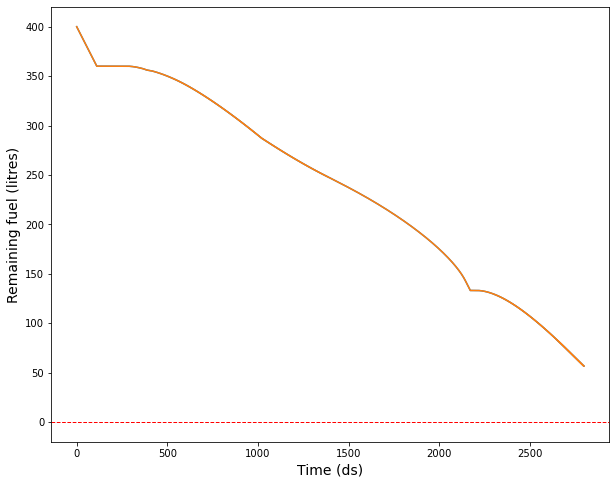

In [25]:
# Fuel plot

plt.plot(Fs[0:2800]) # change number according to previous simulation run
plt.axhline(0,color='r', linestyle='dashed', linewidth=1)
plt.xlabel("Time (ds)", size=14)
plt.ylabel("Remaining fuel (litres)", size=14)

Text(0, 0.5, 'Horizontal Speed (m/s)')

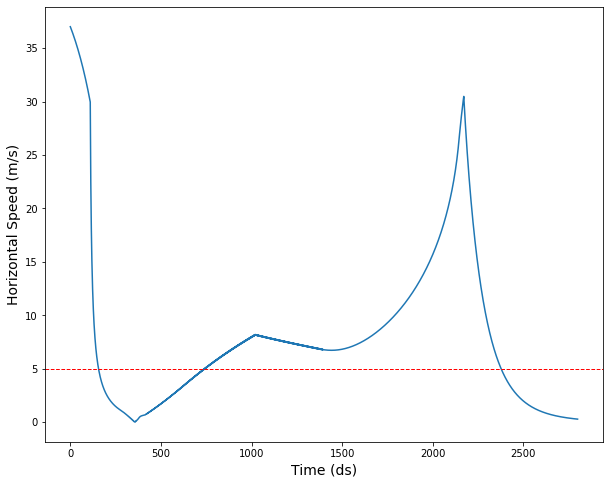

In [26]:
# Horizontal Speed plot

plt.plot(abs(Vs[0:2800,0])) # change number according to previous simulation run
plt.axhline(5,color='r', linestyle='dashed', linewidth=1)
plt.xlabel("Time (ds)", size=14)
plt.ylabel("Horizontal Speed (m/s)", size=14)

Text(0, 0.5, 'Vertical Speed (m/s)')

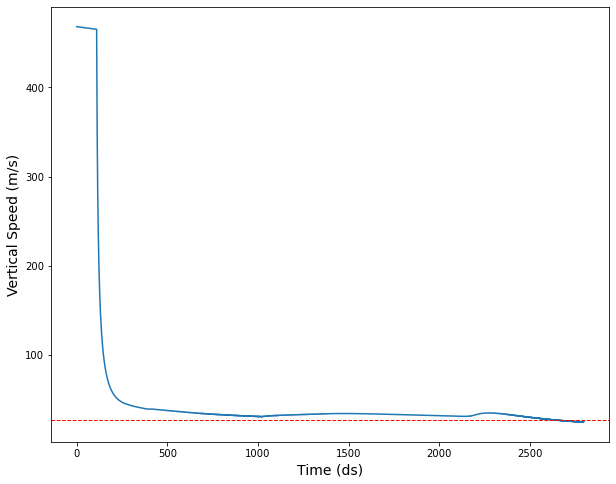

In [27]:
# Vertical Speed plot

plt.plot(abs(Vs[0:2800,1])) # change number according to previous simulation run
plt.axhline(27,color='r', linestyle='dashed', linewidth=1)
plt.xlabel("Time (ds)", size=14)
plt.ylabel("Vertical Speed (m/s)", size=14)
#plt.title("...")

# comment for discussion: huge descent due to openning of the parachute